# <span style='color:Red'> ONGOING PROJECT  </span>

# Heart Disease Identification - Multiclass Classification

This project aims at analysising provided patients health attributes for further identification of heart disease. In this way, not only the presence of heart disease is studied but also the type of the disease, having four different possible disease categories. For that end, a database containing fourteen charasteritic features for each patient, including the actual diagnosis results, is used for training selected prediction algorithms. Hence, a series of classification models are tested and assessed based on the principles of supervised learning. Furthermore, the predictive performance of the models is evaluated considering both binary (predict if disease exists) and multiclass clasification (predict the type of disease).

<img src="./heart.jpg" width=800 height=300 />

## Table of Contents

* [1. Data exploration](#chapter1)
    * [1.1. Preliminary data overview](#section_1_1)
    * [1.2. Data types and invalid values](#section_1_2)
    * [1.3. Train and test Data](#section_1_3)
    * [1.4. Data visalization](#section_1_4)
    * [1.5. Attributes on heart disease](#section_1_5)
        * [1.5.1. Binary target - Presence of Heart Disease](#section_1_5_1)
        * [1.5.1. Multiclass target - Type of Heart Disease](#section_1_5_2)
* [2. Classification Models](#chapter2)
    * [2.1. Data pre-processing](#section_2_1)
    * [2.2. Model training and assessment](#section_1_2)
    * [2.3. Selection](#section_1_3)

# 1. Data Exploration <a class="anchor" id="chapter1"></a>

In [458]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, validation_curve, learning_curve

from sklearn.metrics import classification_report, matthews_corrcoef, roc_auc_score, confusion_matrix, accuracy_score,recall_score


## 1.1. Preliminary data overview  <a class="anchor" id="section_1_1"></a>

Let's first fetch the data! In this case, the datafile does not contain the feature names, so we need to add them manually:

In [459]:
data_path = os.getcwd()
data_file = 'processed.cleveland.data'

features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

data = pd.read_csv(data_path+'/'+data_file,  sep="," , names= features, header=0)

For a better understanding of features contained in the datafile, here is a summary with their meaning:

1. age: age in years
2. sex: sex of the patient (1 = male; 0 = female) 
3. cp: chest pain type 
    - 1: typical angina
    - 2: atypical angina
    - 3: non-anginal pain
    - 4: asymptomatic 
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
5. chol: serum cholestoral in mg/dl 
6. fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false) 
7. restecg: resting electrocardiographic results
    - 0: normal
    - 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. thalach: maximum heart rate achieved 
9. exang: exercise induced angina (1 = yes; 0 = no) 
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - 1: upsloping
    - 2: flat
    - 3: downsloping 
12. ca: number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
14. target: diagnosis of heart disease (angiographic disease status) 

Let's now take look at our dataset:

In [460]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


In [461]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    object 
 12  thal      302 non-null    object 
 13  target    302 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


In [462]:
print(f'There are {data.shape[0]} patients with {data.shape[1]} features')

There are 302 patients with 14 features


We also look at our target attribute. As we can see, there are 4 possible categories with a clear imbalanced representation. As previously mentioned, value 0 corresponds to healthy patients whereas positive heart disease is categorised based on the four remaining values from 1 to 4:

In [463]:
data.loc[:,'target'].value_counts()

0    163
1     55
2     36
3     35
4     13
Name: target, dtype: int64

### 1.2. Data types and invalid values <a class="anchor" id="section_1_2"></a>

We now make sure there are neither missing values nor duplicated data:

In [464]:
data.duplicated().any()

False

In [465]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Nonetheless, when doing data exploration, we noticed have some values of 'thal' which are no valid:

In [466]:
data[data.thal == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
86,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
265,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


In [467]:
data[data.ca == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
165,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
191,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
286,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
301,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Considering there are just a few rows affected, we can just remove them without losing too much information:

In [468]:
data.drop(data[data.thal == '?'].index, inplace=True)
data.drop(data[data.ca == '?'].index, inplace=True)

In [469]:
data[data.ca == '?'].index

Int64Index([], dtype='int64')

Last but not least, we check the type of each feature:

In [470]:
data.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
target        int64
dtype: object

As observed, features 11 and 12 are considered object types. Let's now define them as numerical:

In [471]:
data[['ca','thal']] = data[['ca','thal']].astype('float64')

In [472]:
data.reset_index(drop=True,inplace=True)

## 1.3.  Train and test data <a class="anchor" id="section_1_3"></a>

Let's now split the dataset by saving the features and target values separately:

In [473]:
y = data.target
X = data.drop(['target'], axis=1)

We now further split the data into training and test datasets. The training data will be used by the model to learn and refine its performance when making predictions. The test data however, will not be part of the training process and thus, it will guarantee to assess the actual performance of the model when applied to unseen features. In this case, we set the training data to be 80% of the input dataset and the remaining 20% to be the test data.

In [474]:
data_train, data_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.75, test_size=0.25, random_state=0)

As previously explained, target values above zero correspond to different levels of positive heart disease whereas zero values correspond to healthy patients. Taking this into account, we can make a binary distinction considering if a heart disease is present or not (0: 0 healthy patients, 1: 1-4 existing heart disease). Based on this, we generate new series containing binary target values:

In [475]:
y_train_binary= []

for num in y_train:
    if num !=0:
        y_train_binary.append(1)
    else:
        y_train_binary.append(0)

y_test_binary= []

for num in y_test:
    if num !=0:
        y_test_binary.append(1)
    else:
        y_test_binary.append(0)

In [476]:
y_train_binary = pd.Series(y_train_binary, name= y_train.name)
y_test_binary = pd.Series(y_test_binary, name= y_test.name)

Once we have our training data defined, we check the amount of unique values that each feature can adopt and their type:

In [477]:
df_type_num = pd.DataFrame(data=zip(data_train.dtypes,data.nunique()), columns=['Type', 'Unique'], index = data_train.columns)
df_type_num

,Type,Unique
age,float64,41
sex,float64,2
cp,float64,4
trestbps,float64,50
chol,float64,152
fbs,float64,2
restecg,float64,3
thalach,float64,91
exang,float64,2
oldpeak,float64,40


## 1.4.  Data Visualization <a class="anchor" id="section_1_3"></a>

For a better exploration of our data, let's copy our training dataset and change the numerical values of our categorical data to informative labels. This will allow a better understading and overview of the information provided. 

In [478]:
data_train_lb = data_train.copy()

In [479]:
fts_cat = {'sex': {'0': 'Female', '1':'Male'}, 'fbs': {'0': 'False', '1': 'True'}, 
        'cp': {'1':'typical', '2': 'atypical', '3': 'non-anginal', '4': 'asymptomatic '},
        'restecg':{'0':'normal','1': 'abnormality', '2':'hypertrophy'},
        'exang': {'1':'yes','0':'no'}, 'slope': {'1':'up','2':'flat','3':'down'},
        'thal':{'3': 'normal','6': 'fixed','7': 'reversable'}}

We assume that all features with less than 6 values correspond to categorical features whereas a large number of unique values correspond to continuous numerical features. 

In [480]:
cat = df_type_num[df_type_num['Unique'] < 6]
cat

,Type,Unique
sex,float64,2
cp,float64,4
fbs,float64,2
restecg,float64,3
exang,float64,2
slope,float64,3
ca,float64,4
thal,float64,3


We can see that the attributes identified as categorical features are certainly so.

In [481]:
cat_ft = list(cat.index)

We set their type to object:

In [482]:
data_train_lb[cat_ft] = data_train_lb[cat_ft].astype('object')

We check again the types:

In [483]:
data_train_lb.dtypes

age         float64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
dtype: object

Now we add informative values:

In [484]:
for ft in fts_cat.keys():
    values = data_train_lb[ft].unique()
    for val in values:
        data_train_lb.loc[data_train_lb[ft] == val, ft] = fts_cat[ft][f'{int(float(val))}']

Therefore, the remaining features correspond to continuous numerical values:

In [485]:
num_ft = list(data_train_lb.select_dtypes(exclude=['object']).columns)

We look again at our dataset to see how it looks now:

In [486]:
data_train_lb.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
249,51.0,Female,non-anginal,120.0,295.0,False,hypertrophy,157.0,no,0.6,up,0.0,normal
69,65.0,Female,non-anginal,155.0,269.0,False,normal,148.0,no,0.8,up,0.0,normal
137,51.0,Male,non-anginal,125.0,245.0,True,hypertrophy,166.0,no,2.4,flat,0.0,normal
210,52.0,Male,asymptomatic,112.0,230.0,False,normal,160.0,no,0.0,up,1.0,normal
222,47.0,Male,asymptomatic,112.0,204.0,False,normal,143.0,no,0.1,up,0.0,normal


It should be noted that looking at the proportion of our target values is crucial to see if one category is over or under represented.
Looking at he proportion of negative and positive heart disease cases in the figure below, we can see there is not a large imbalance in the data.

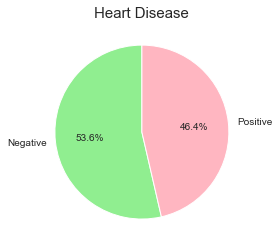

In [487]:
dict_binary = {'0': 'Negative', '1':'Positive'}
labels = [dict_binary[str(lb)] for lb in y_train_binary.value_counts().index]
plt.pie(y_train_binary.value_counts(), labels= labels, startangle=90, autopct='%1.1f%%', colors = ['lightgreen','lightpink']);

plt.gca().set_title('Heart Disease', fontsize= '15');

If we now consider four target categories, a notable imbalance is observed. As seen in the figure below, level zero is over-represented compared to the rest of categories. Furthemore, the higher levels are the most under-represented. This uneven representation of our target values is critical and one should take this into account when training the model. 

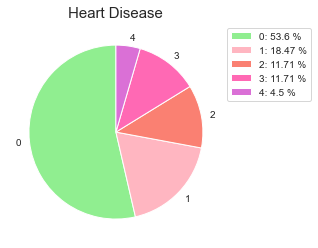

In [488]:
labels = y_train.value_counts().index
counts = y_train.value_counts()
plt.pie(counts, labels= labels, startangle=90, colors = ['lightgreen','lightpink', 'salmon', 'hotpink','orchid']);
labels_box = [f'{label}: {round(c*100/data_train_lb.shape[0],2)} %' for label, c in zip(labels, counts)]
plt.gca().legend(labels_box, loc='best', bbox_to_anchor=(0.99, 1.0), fontsize=10)
plt.gca().set_title('Heart Disease', fontsize= '15');

Let's finally check the characteristics of our categorical features. For a better understanding, we create a dictionary with more informative feature names:

In [489]:
dict_fts = {'age': 'Age','sex': 'Sex', 'cp': 'Chest Pain', 'trestbps':'Resting Blood Pressure', 'chol': 'Serum Cholestoral [mg/dl]', 'fbs': 'Fasting Blood Sugar [> 120 mg/dl]', 
'restecg':'Resting Electrocardiographic Results', 'thalach':'Maximum Heart Rate Achieved', 'exang':'Exercise Induced Angina',
'oldpeak':'OldPeak','slope': 'Slope','ca':'Major Vessels','thal':'Thalassemia', 'target':'Heart Disease'}

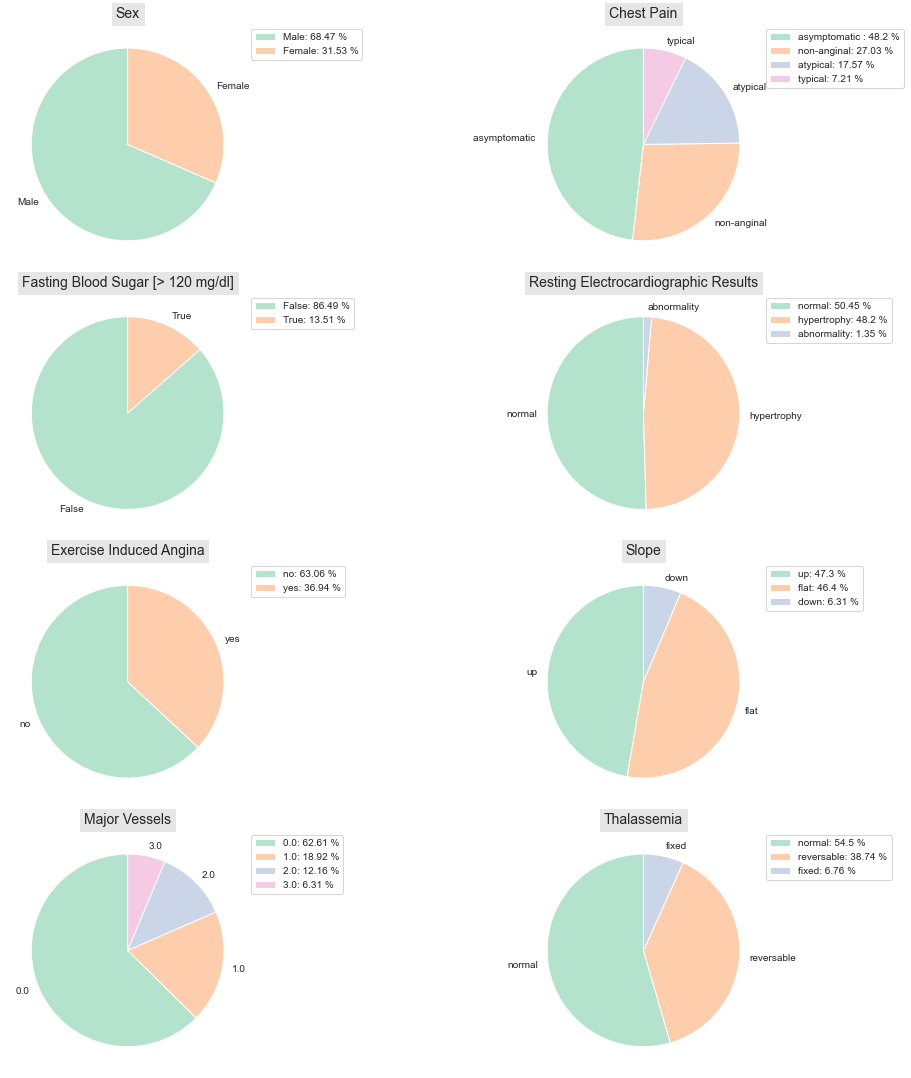

In [490]:
num = len(cat_ft)
fig = plt.figure(figsize=(15,30))

for i, ft in enumerate(cat_ft):

    counts = data_train_lb[ft].value_counts()
    colors = sns.color_palette('Pastel2')[0:len(counts)]
    labels = list(counts.index)

    plt.subplot(num,2,i+1)
    plt.pie(counts, colors= colors, startangle=90, labels = labels);

    plt.gca().set_title(dict_fts[ft], fontsize='14', bbox={'facecolor':'0.9', 'pad':5})

    labels_box = [f'{label}: {round(c*100/data_train_lb.shape[0],2)} %' for label, c in zip(labels, counts)]
    plt.gca().legend(labels_box, loc='best', bbox_to_anchor=(0.99, 1.0), fontsize=10)

    i=i+1

plt.tight_layout()


## 1.5.  Attributes influence on heart disease <a class="anchor" id="section_1_5"></a>

### 1.5.1. Binary target - Presence of heart disease <a class="anchor" id="section_1_5_1"></a>

Let's now take a closer look into the features relation with the target! We first look at out categorical features and how they relate to the existence of heart disease:

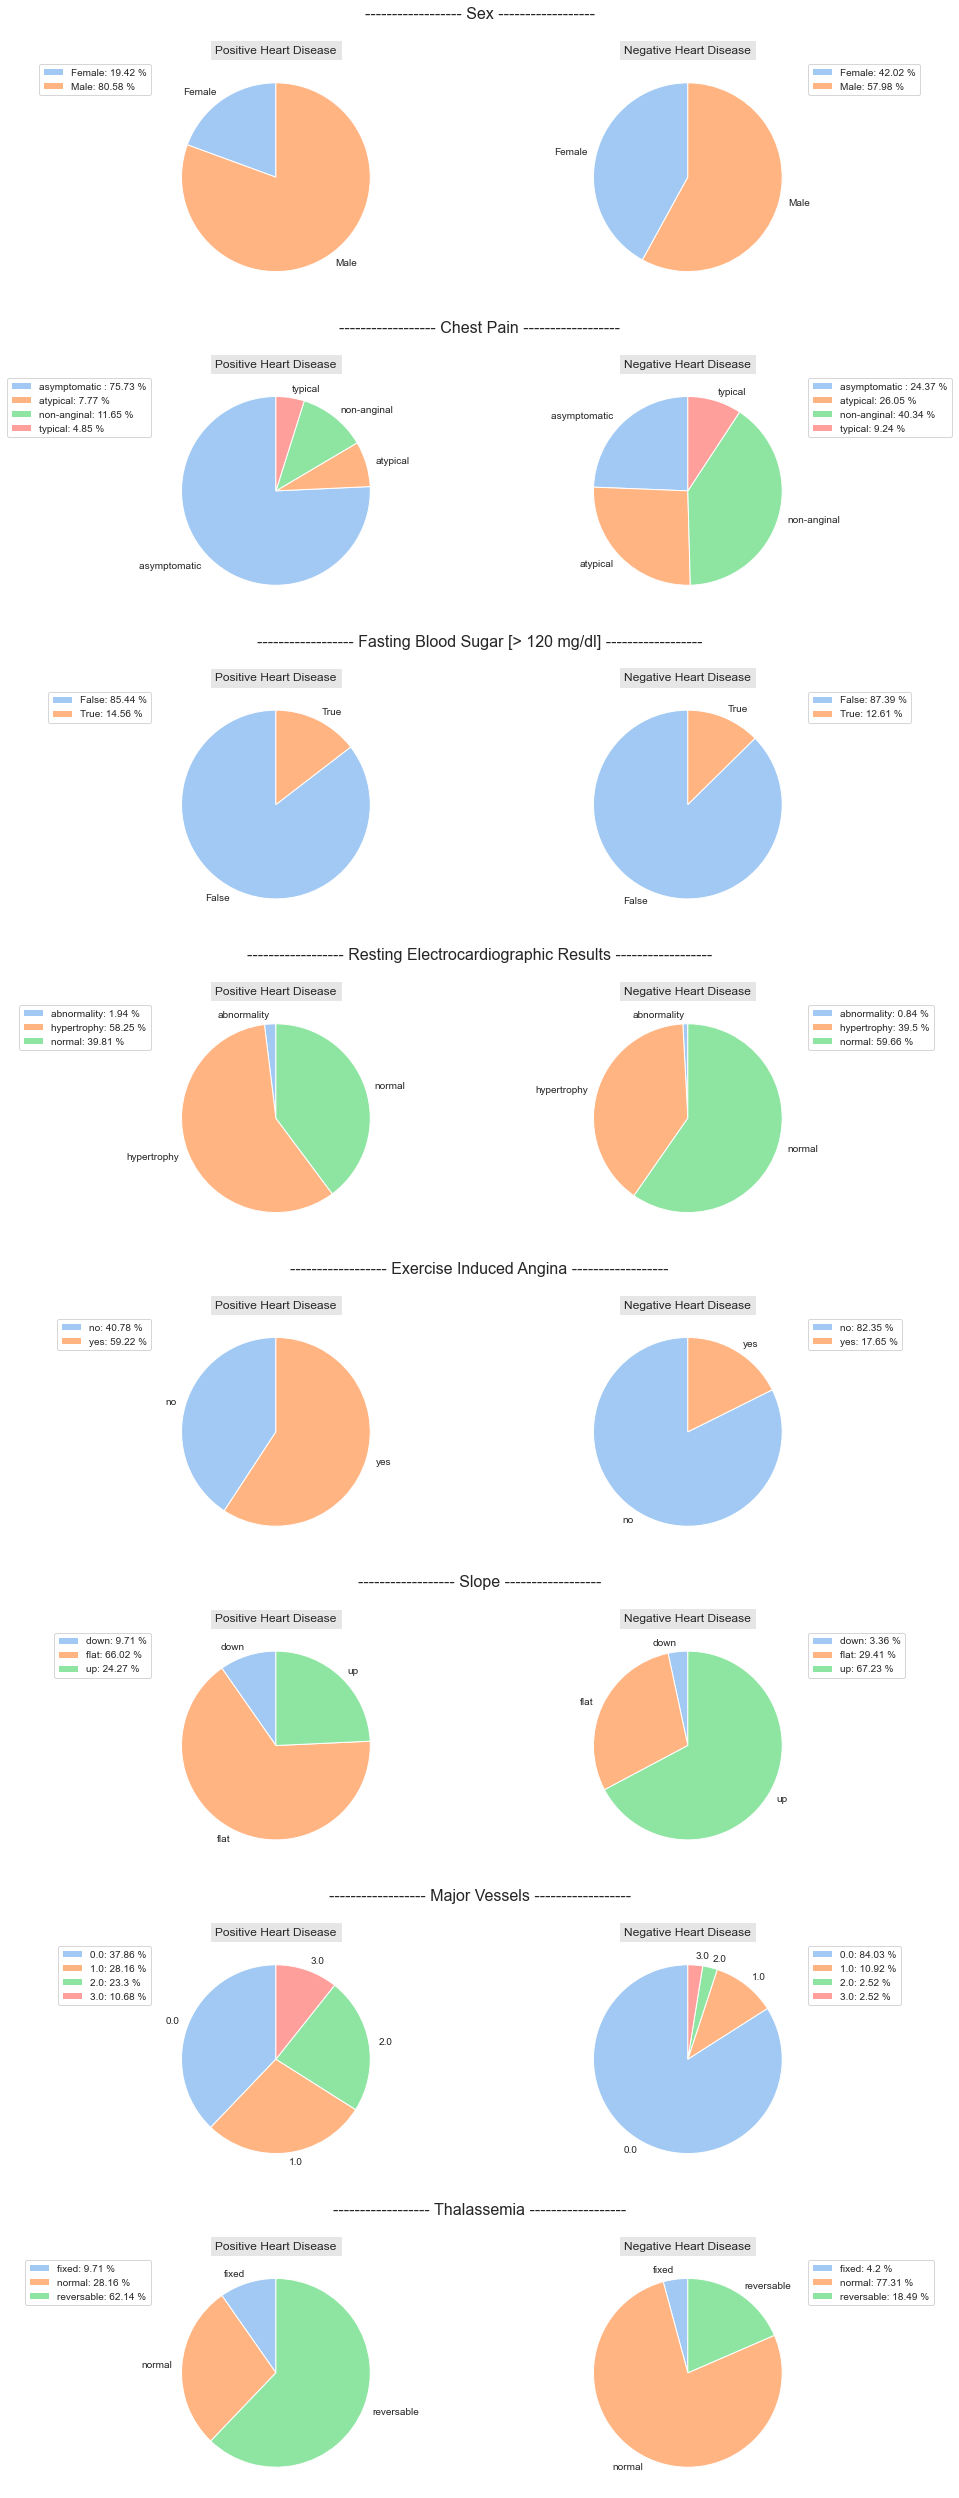

In [439]:
df_filtered = data_train_lb[cat_ft].nunique()
num_plots = len(df_filtered)
i=1

data_positive = data_train_lb[y_train!=0]
data_negative = data_train_lb[y_train==0]

fig, big_axes = plt.subplots(figsize=(15.0, 35.0) , nrows=num_plots, ncols=1) 

for row, big_ax in enumerate(big_axes, start=1):
    ft = df_filtered.index[row-1]
    big_ax.set_title(f'------------------ {dict_fts[ft]} ------------------ \n \n', fontsize=16)
    big_ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft = False, labelbottom = False )
    big_ax._frameon = False
    big_ax.grid(False)


for ft in df_filtered.index:

    ax = fig.add_subplot(num_plots,2,i)
    pos_ft_num = data_positive[ft].value_counts().sort_index()
    labels = list(pos_ft_num.index)

    colors = sns.color_palette('pastel')[0:len(pos_ft_num)]

    ax.pie(pos_ft_num, labels=labels, colors = colors, startangle=90)
    ax.set_title('Positive Heart Disease', bbox={'facecolor':'0.9', 'pad':5})
    labels_box = [f'{label}: {round(counts*100/data_positive.shape[0],2)} %' for label, counts in zip(labels, pos_ft_num)]
    ax.legend(labels_box, loc='best', bbox_to_anchor=(-0.01, 1.0), fontsize=10)


    ax = fig.add_subplot(num_plots,2,i+1)
    neg_ft_num = data_negative[ft].value_counts().sort_index()
    labels = list(neg_ft_num.index)


    ax.pie(neg_ft_num, labels= labels, colors= colors, startangle=90)
    ax.grid(None)
    ax.set_title('Negative Heart Disease', bbox={'facecolor':'0.9', 'pad':5})
    labels_box = [f'{label}: {round(counts*100/data_negative.shape[0],2)} %' for label, counts in zip(labels, neg_ft_num)]
    ax.legend(labels_box, loc='best', bbox_to_anchor=(0.99, 1.0), fontsize=10)


    i=i+2


#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

Based on the previous plots, we can see that positive heart disease cases are mainly men with asymptomatic chest pain, flat slope and reversable thalassemia. In these cases, the exercise induced angina does not show a strong impact, having similar representation both positive and negative results. Looking at the major vessels, we can clearly see that, in general, a non-zero number of vessels are observed when heart disease is present. Nonetheless, we can observe that the probability of finding vessels slightly decreases with the number of these. Therefore, it is more probable to observe one major vessel than three.

On the other hand, negative cases are mainly represented by positive exercise induced angina, upwards slope, zero major vessels and normal thalassemia. Furthemore, non-anginal chest pains seems to be the most probable one, followed by asymptomatic chest pain with much less representation compared to positive heart disease cases. Moreover, we can see a balanced proportion of men and women.

Finally, we can observe that fasting blood sugar does not have a strong impact on the existence of heart disease, showing both positive and negative cases similar behaviour in this aspect.

Let's now look into our numerical features:

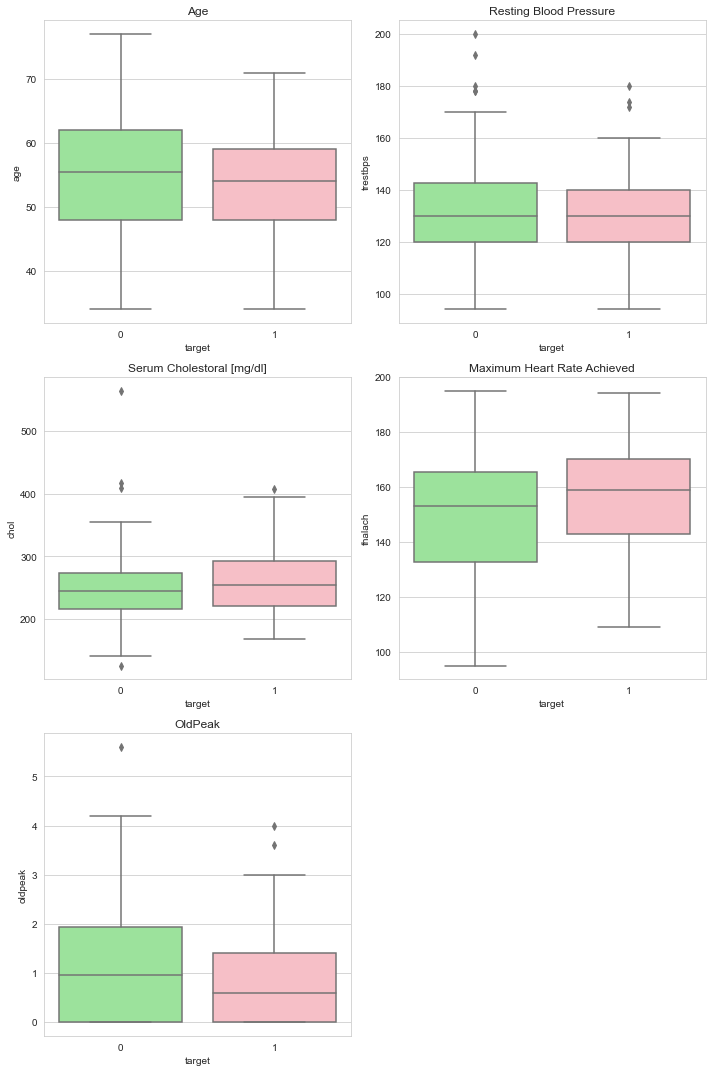

In [440]:
n_rows = len(num_ft)//2 + len(num_ft)%2

fig = plt.figure(figsize=(10.0, 15.0)) 

i=1
for ft in num_ft:

    plt.subplot(n_rows,2,i)
    sns.boxplot(y=data_train[ft], x =y_train_binary, palette = ['lightgreen','lightpink'])
    if ft in dict_fts:
        ft = dict_fts[ft]
        
    plt.title(f'{ft}')


    i=i+1
#fig.set_facecolor('w')
plt.tight_layout()
plt.show()

As observed, positive diagnosis is usually found in older patients. Moreover, oldpeak values also seem to be higher in positive cases compared to healthy patients. Despite having similar mean maximum heart rate, we can also observe there is a larger proportion of sick patients with lower heart rate compared to healthy cases. Looking at the results from resting blood pressure and serum cholestoral, no significant difference is observed, thus presenting less impact on the diagnosis compared to other features.

Another way of visualizing at the previous numerical attributes is by making pair plots which also take into account the diagnosis:

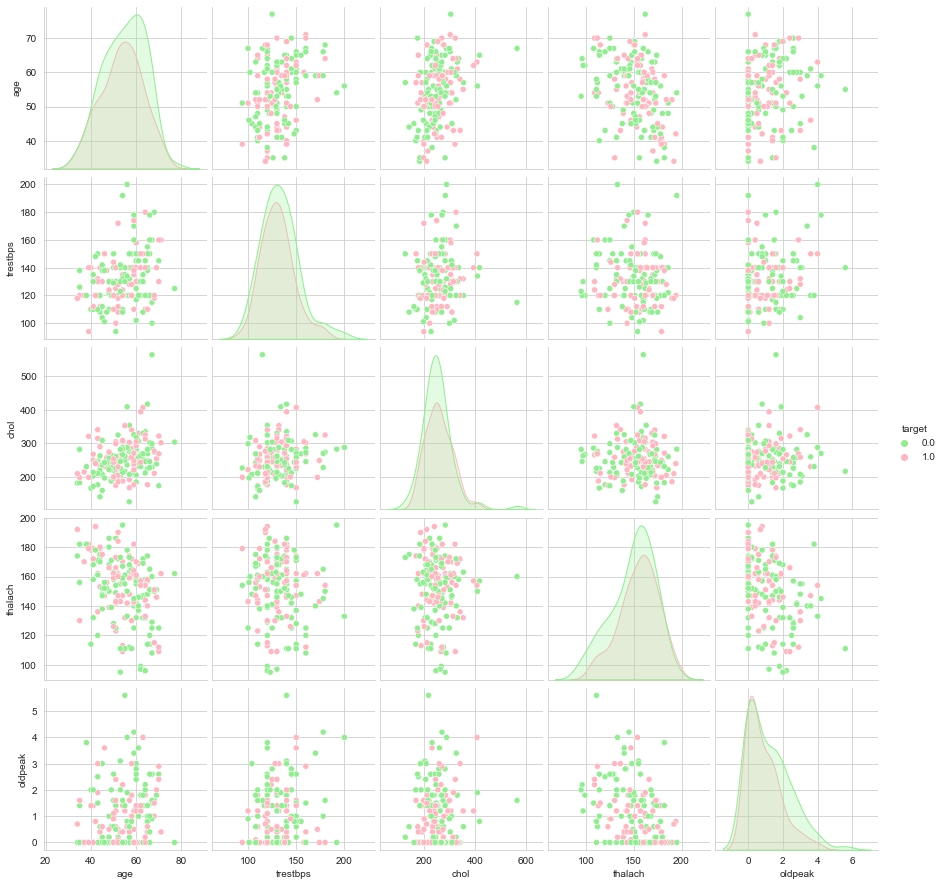

In [441]:
sns.pairplot(pd.concat([data_train_lb[num_ft], y_train_binary], axis=1), hue= 'target', diag_kind="kde", palette = ['lightgreen','lightpink'])

### Mutual information score

Mutual information allows us to measure of the similarity between two attributes. In this way, we can evaluate the level of influence of our features on a positive diagnosis of heart disease. Let's create a function that computes the mutual information scores and plot the results:

In [442]:
def make_plot_scores(dataset, feature, regression=False, cat_cols= cat_ft):

    # Create a copy of the train data removing all the rows containing missing values
    df_copy = dataset.dropna().copy()

    # We set the target
    y_copy = feature.copy()

    discrete_features = df_copy.columns.isin(cat_cols)

    # Obtain scores of mutual information

    if regression:
        scores = mutual_info_regression(df_copy, y_copy, discrete_features=discrete_features, random_state = 1)
        pass
    else:
        scores = mutual_info_classif(df_copy, y_copy, discrete_features=discrete_features, random_state = 1)

    list_features = []

    for name_ft in df_copy.columns:
        list_features.append(dict_fts[name_ft])

    scores = pd.Series(scores, name="Scores", index=list_features)

    # Retain positive non-zero scores
    scores = scores[scores > 0].sort_values(ascending = False)
    
    # Create bar plot
    width = np.arange(len(scores))
    ticks = list(scores.index)

    sns.set_style('whitegrid')
    sns.barplot(x = scores, y = width, orient='h', color='lightseagreen')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    return scores.sort_values(ascending = False)

Let's calculate the features influence on the heart disease presence:

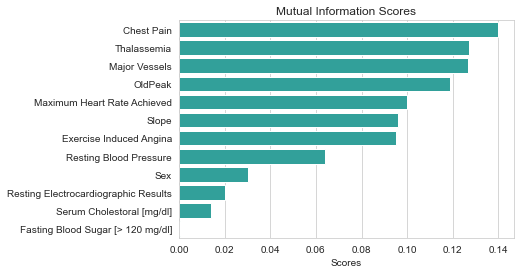

In [443]:
scores = make_plot_scores(dataset= data_train, feature=y_train_binary)

Based on the computed scores, the most influential features are the thalassemia results, the number of major vessels and the chest pain, followed by the maximum heart rate achieved. This outcome also coindices with the observations made previously.

### 1.5.2. Multiclass target - Type of heart disease <a class="anchor" id="section_1_5_2"></a>

We now do the same considering all four disease levels:

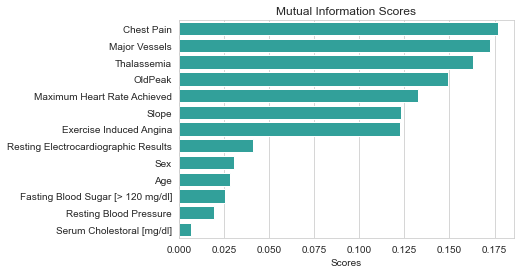

In [444]:
scores = make_plot_scores(dataset= data_train, feature=y_train)

According to the obtained scores, the features that have the most influence on the disease level are also the thalassemia results, the number of major vessels, the chest pain. 

In [445]:
def make_barplot(feature1, feature2, dataset = data_train, horizontal = False):


    dataset_obj = dataset.copy()

    color_palette = ['lightgreen','lightpink', 'salmon', 'hotpink','orchid']  

    if horizontal: 

        df = dataset_obj.groupby(feature1)[feature2].value_counts(normalize=True).mul(100).rename('Percentage %').reset_index()
       
        sns.barplot(y=feature1, x='Percentage %', hue=feature2, data=df, orient= 'h', palette = color_palette, edgecolor=(0,0,0))
        plt.xlim([0,100])

        if feature2 in dict_fts.keys():
            title = dict_fts[feature2]
        else:
            title=feature2
            
        plt.legend(loc='best', title=title)
        fg = plt.gcf()
        ax = plt.gca()

        for p in ax.patches:
            ax.annotate(f'{round(p.get_width(),1)}%', 
                        (p.get_width(), p.get_y() + p.get_height() / 2.), 
                        ha = 'center', va = 'center', 
                        xytext = (30, 0), 
                        textcoords = 'offset points')

    else: 

        df = dataset_obj.groupby(feature1)[feature2].value_counts(normalize=True).mul(100).rename('Percentage %').reset_index()
        sns.barplot(x=feature1, y='Percentage %', hue=feature2, data=df, palette = color_palette, edgecolor=(0,0,0)) 

        plt.ylim([0,100])
        if feature2 in dict_fts.keys():
            title = dict_fts[feature2]
        else:
            title=feature2
        plt.legend(loc='best', title=title)

        fg = plt.gcf()
        ax = plt.gca()

        for p in ax.patches:
            ax.annotate(f'{round(p.get_height(),1)}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

    return (ax, fg)

### Heart Disease Diagnosis - Chest Pain

Looking at the effect of the chest pain on heart disease, we clearly observe the asymptomatic behaviour to be the most predominant one in all the positive disease cases. On the other hand, the non-aginal pain is the most probable one in the healthy patients and decresases its presence as the level of the disease increases. 

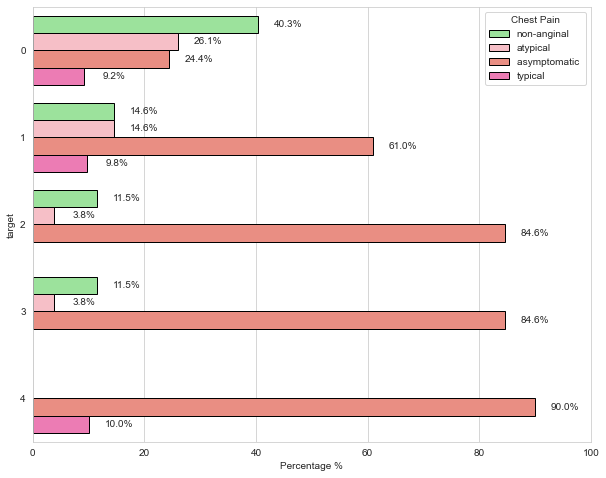

In [446]:
plt.figure(figsize=(10,8))
ax, fg = make_barplot('target','cp', dataset= pd.concat([data_train_lb,y_train], axis=1), horizontal=True)

### Heart Disease Diagnosis - Number of Major Vessels

In the case of major vessels, it can be observed that its number increases proportional to the disease level. Thus, healthy cases mostly present zero visible major vessels whereas patients with disease level 4 mainly present three vessels.

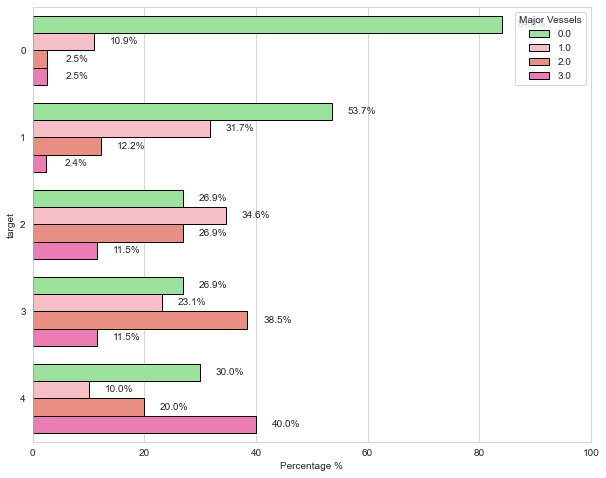

In [447]:
plt.figure(figsize=(10,8))
ax, fg = make_barplot('target','ca', dataset= pd.concat([data_train_lb,y_train], axis=1), horizontal=True)

### Heart Disease Diagnosis - Thalassemia

Let's first look at the distribution of the possible thalassemia categories based on the heart disease level. As expected, healthy patients are mainly characterised by normal thalassemia with nearly 80% of probability. On the other hand, positive heart disease patients are more probable to present reversable thalassemia. We can also see that the probability of having normal thalassemia decreses as the disease level increases.

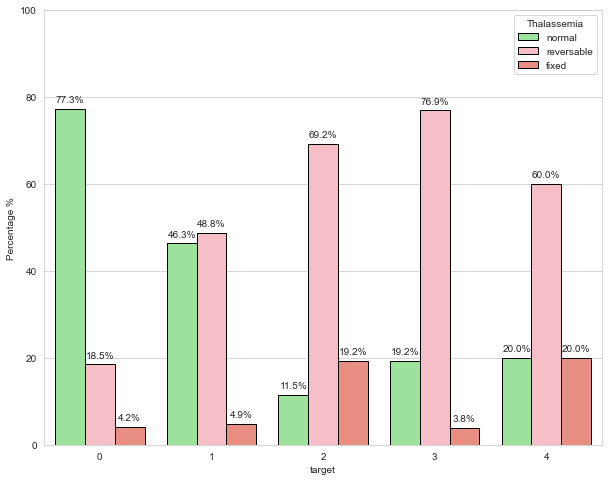

In [448]:
plt.figure(figsize=(10,8))
ax, fg = make_barplot('target','thal', dataset= pd.concat([data_train_lb,y_train], axis=1))

### Heart Disease Diagnosis - Old Peak

In [449]:
def make_boxes(dataset, ft_x,ft_y):

    fig = plt.figure(figsize=(10.0, 6.0)) 
    color_palette = ['lightgreen','lightpink', 'salmon', 'hotpink','orchid']

    sns.boxplot(y=data_train[ft_x], x =ft_y, palette = color_palette)

    if ft_x in dict_fts:
        ft_x = dict_fts[ft_x]
        
    plt.title(f'{ft_x}')

    plt.show()

The oldpeak distribution of values for each disease type is shown the figure below. We can observe that the oldpeak values generally increase with the disease level:

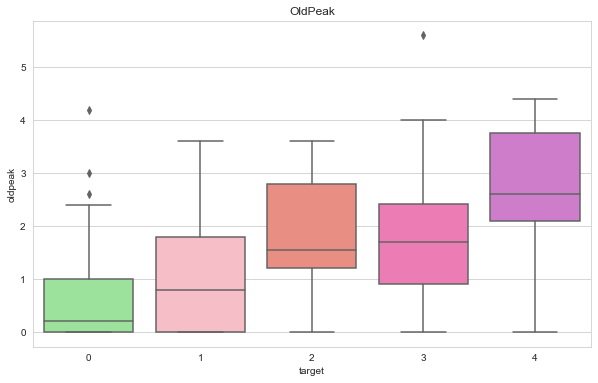

In [450]:
make_boxes(data_train, 'oldpeak', y_train)

### Heart Disease Diagnosis - Maximum Heart Rate Achieved

In the case of the maximum heart rate achieved, we can see that higher rates are usually found at healthy patients followed by low disease levels:

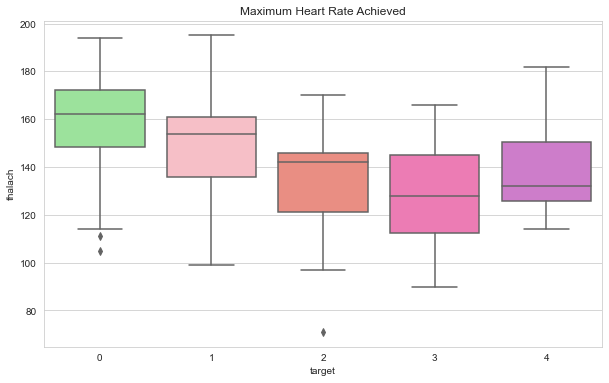

In [451]:
make_boxes(data_train, 'thalach', y_train)

### Heart Disease Diagnosis - Excercised Induced Angina

If we now look at the distribution of exercised induced angina, we can clearly see that negative cases are the majority in hearlthy cases (nearly 80%). Nonetheless, it is seen that the number of positive cases escalates as the disease level increases, representing nearly 80% of the cases in the third disease type. It should be noted though, that both positive and negative cases are equally present in the fourth heart disease type.  

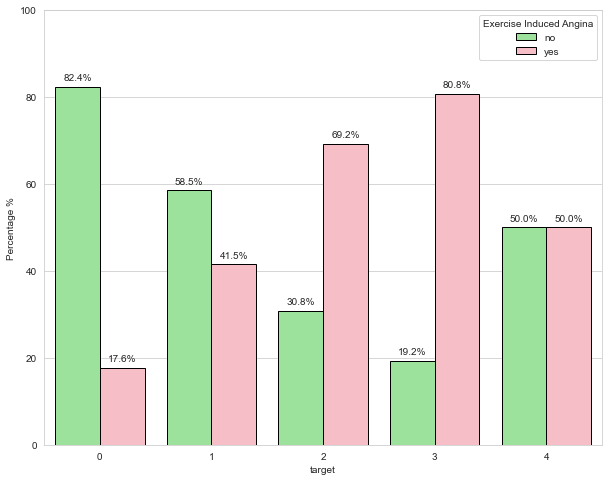

In [452]:
plt.figure(figsize=(10,8))
ax, fg = make_barplot('target','exang', dataset= pd.concat([data_train_lb,y_train], axis=1))

### Heart Disease Diagnosis - Slope

As shown in the figure below, we can clearly see that upwards slope is mainly found in healthy patients, as expected from previous observations. Once the disease is detected, the most probable slope to observe is the flat slope. Moreover, the presence of upward slopes decreases as the level of heart disease increases. Even though the flat behaviour is the most probable one to find in all disease levels, we can observe that downwards slope is more present at the highest levels.

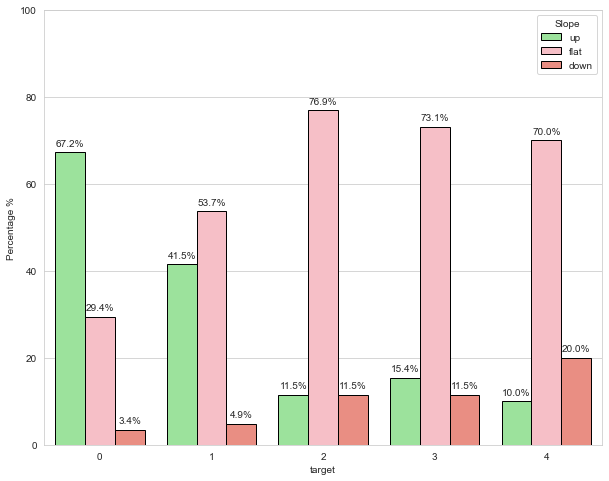

In [453]:
plt.figure(figsize=(10,8))
ax, fg = make_barplot('target','slope', dataset= pd.concat([data_train_lb,y_train], axis=1))

# 2. Classification Models <a class="anchor" id="chapter2"></a>

## 2.1. Data pre-processing  <a class="anchor" id="section_2_1"></a>

### 2.1.1. Encode categorical features  <a class="anchor" id="section_2_1_1"></a>

In [454]:
# Apply one-hot encoder to each column with categorical data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_encoded = pd.DataFrame(encoder.fit_transform(data_train[cat_ft]))
test_encoded = pd.DataFrame(encoder.transform(data_test[cat_ft]))

# One-hot encoding removed index; put it back
train_encoded.index = data_train.index
test_encoded.index = data_test.index

train_encoded.columns = encoder.get_feature_names(cat_ft)
test_encoded.columns = encoder.get_feature_names(cat_ft)


# Remove categorical columns (will replace with one-hot encoding)
num_train = data_train.drop(cat_ft, axis=1)
num_test = data_test.drop(cat_ft, axis=1)

# Add one-hot encoded columns to numerical features
train_encoded = pd.concat([num_train, train_encoded], axis=1)
test_encoded = pd.concat([num_test, test_encoded], axis=1)

/Users/nour/Python/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [455]:
train_encoded[train_encoded.columns.difference(num_ft)].head()

,ca_0.0,ca_1.0,ca_2.0,ca_3.0,cp_1.0,cp_2.0,cp_3.0,cp_4.0,exang_0.0,exang_1.0,...,restecg_1.0,restecg_2.0,sex_0.0,sex_1.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
249,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
69,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
137,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### 2.1.2. Scale numerical features  <a class="anchor" id="section_2_1_2"></a>

In [456]:
scaler = StandardScaler()

train_scaled= pd.DataFrame(scaler.fit_transform(train_encoded[num_ft]))
test_scaled= pd.DataFrame(scaler.transform(test_encoded[num_ft]))

# One-hot encoding removed index; put it back
train_scaled.index = train_encoded.index
test_scaled.index = test_encoded.index

train_scaled.columns = num_ft
test_scaled.columns = num_ft

# Remove categorical columns (will replace with one-hot encoding)
cat_train = train_encoded.drop(num_ft, axis=1)
cat_test = test_encoded.drop(num_ft, axis=1)

# Add one-hot encoded columns to numerical features
train_prep = pd.concat([cat_train, train_scaled], axis=1)
test_prep = pd.concat([cat_test, test_scaled], axis=1)


In [457]:
train_prep[num_ft].describe()

,age,trestbps,chol,thalach,oldpeak
count,2.220000e+02,2.220000e+02,2.220000e+02,2.220000e+02,2.220000e+02
mean,8.801768e-17,1.960394e-16,2.160434e-16,3.120627e-16,1.600321e-17
std,1.002260e+00,1.002260e+00,1.002260e+00,1.002260e+00,1.002260e+00
min,-2.253367e+00,-2.111365e+00,-2.279342e+00,-3.448884e+00,-9.178287e-01
25%,-7.956412e-01,-6.423680e-01,-6.994224e-01,-5.806551e-01,-9.178287e-01
50%,5.699080e-02,-7.736921e-02,-9.035186e-02,1.336546e-01,-2.075613e-01
75%,7.170930e-01,4.876296e-01,5.599340e-01,7.160918e-01,5.027062e-01
max,2.477365e+00,3.877623e+00,5.743903e+00,2.001849e+00,4.054043e+00


# Model

## Decision Tree

## Random Forest

## Logistic Regression

## K Neighbours

## SVM

## Neural Networks